In [1]:
cd ../src

/Users/dani/Google Drive/Uni/Master/P4 2021/DD2424 - Deep Learning for Data Science/Project/ScarceClassifier/src


In [2]:
from d07_visualization.viz_training import plot_acc, plot_training_loss, plot_losses
from d04_mixmatch.wideresnet import WideResNet
from d02_data.load_data import get_dataloaders_ssl
import torch
import torch.nn as nn

In [4]:
model_name = 'self_contained.pt'
saved_model = torch.load(f'../models/saved_models/{model_name}', map_location=torch.device('cpu')) 

model = WideResNet(depth=28, k=2, n_out=10)
model.load_state_dict(saved_model['model_state_dict'])
#ema_model = WideResNet(depth=28, k=2, n_out=10)
#ema_model.load_state_dict(saved_model['ema_state_dict'])

# optim = ...
# optim.load_state_dict(saved_model['optimizer_state_dict'])

loss_train = saved_model['loss_train']
loss_val = saved_model['loss_val']
acc_train = saved_model['acc_train']
acc_val = saved_model['acc_val']


In [5]:
loss_batch = saved_model['loss_batch']
lx = saved_model['lx']
lu = saved_model['lu']
lu_weighted = saved_model['lu_weighted']

In [6]:
saved_model.keys()

dict_keys(['model_state_dict', 'ema_state_dict', 'optimizer_state_dict', 'loss_train', 'loss_val', 'acc_train', 'acc_val', 'loss_batch', 'lx', 'lu', 'lu_weighted'])

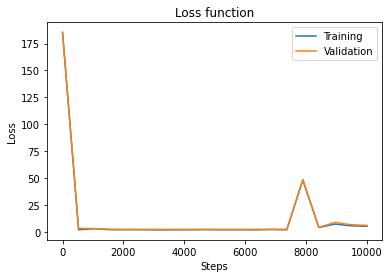

In [7]:
plot_training_loss(loss_train, loss_val, step=500)


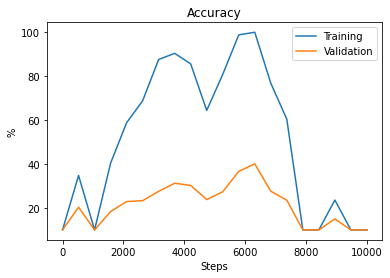

In [8]:
plot_acc(acc_train, acc_val, step=500)

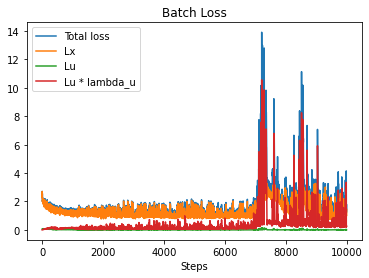

In [9]:
plot_losses(loss_batch, lx, lu, lu_weighted)

In [19]:
def evaluate(dataloader):
    criterion = nn.CrossEntropyLoss()
    model.eval()
    correct, total, loss = 0, 0, 0
    with torch.no_grad():
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data[0], data[1]
            outputs = model(inputs)
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = correct / total * 100
    return loss, acc

_, _, _, test_loader = get_dataloaders_ssl(path='../data', batch_size=64, num_labeled=250)
test_val, test_acc = evaluate(test_loader)
print("Test accuracy: %.3f" % (test_acc))

Files already downloaded and verified
Files already downloaded and verified
Test accuracy: 35.220
